In [9]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
import scipy as sp
import csv

from sklearn.pipeline import Pipeline

from swimnetworks import (Dense, Linear)
np.set_printoptions(threshold=np.inf)

In [10]:
def tanh_x(x):
    """First derivative of tanh.
    """
    x = np.clip(x, -10, 10)
    return 1/np.cosh(x)**2

def tanh_xx(x):
    x = np.clip(x, -10, 10)
    return -2*np.tanh(x)*(1-np.tanh(x)**2)

Text(0.5, 1.0, '5th order polynomial')

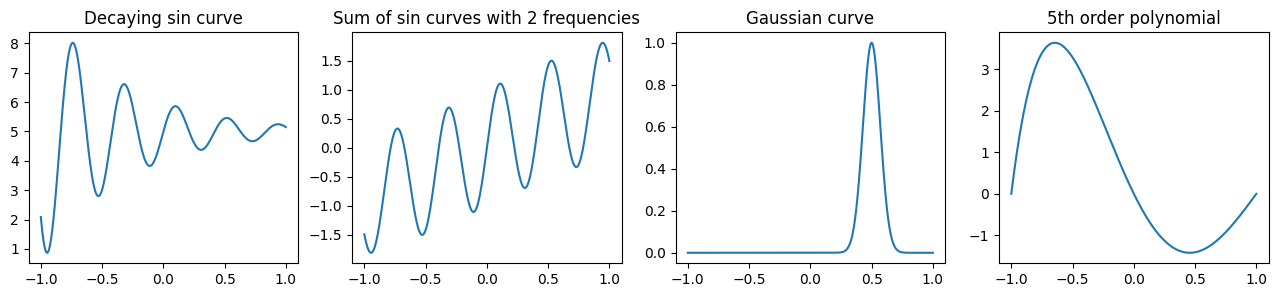

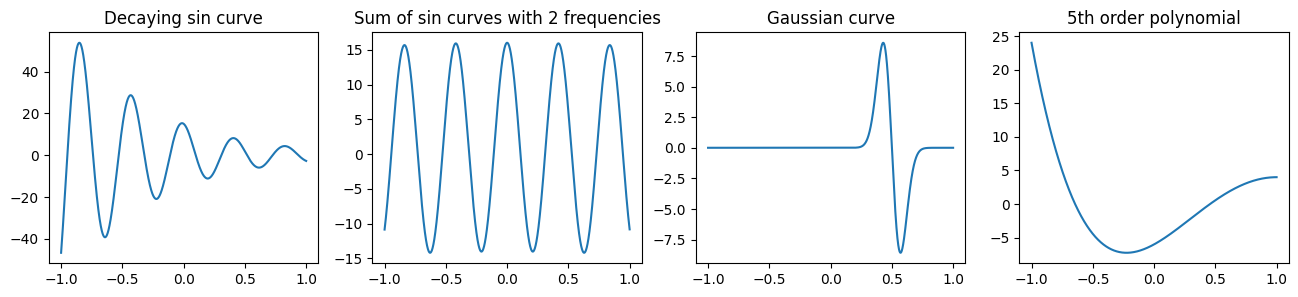

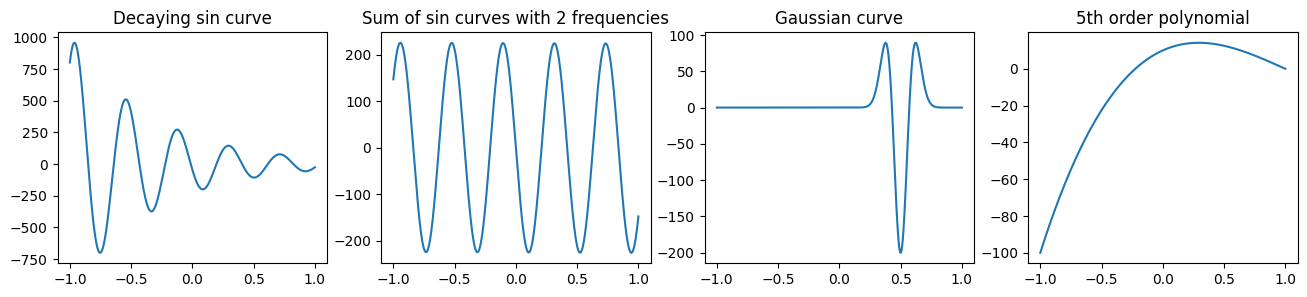

In [11]:
# setup the problem ODE
def u_true_decaying_sine(x):
    return np.sin(15*x)*np.exp(-1.5*x) + 5

def u_grad_decaying_sine(x):
    return 15*np.exp(-1.5*x)*(np.cos(15*x) - 0.1*np.sin(15*x))

def u_laplacian_decaying_sine(x):
    return -np.exp(-1.5*x)*(222.75*np.sin(15*x) + 45*np.cos(15*x))

def u_true_polynomial(x):
    return x**5 - 5*x**4 + 5*x**3 + 5*x**2 - 6*x

def u_grad_polynomial(x):
    return 5*x**4 - 20*x**3 + 15*x**2 + 10*x - 6

def u_laplacian_polynomial(x):
    return 20*x**3 - 60*x**2 + 30*x + 10

def u_true_sine_two_freq(x):
    return np.sin(x) + np.sin(15*x)

def u_grad_sine_two_freq(x):
    return np.cos(x) + 15*np.cos(15*x)

def u_laplacian_sine_two_freq(x):
    return -np.sin(x) -225*np.sin(15*x) 

def u_true_gaussian(x):
    return np.exp(-(x-0.5)**2/0.01) 

def u_grad_gaussian(x):
    return -200*np.exp(-100*(x-0.5)**2)*(x-0.5)

def u_laplacian_gaussian(x):
    return np.exp(-100*(x-0.5)**2)*(40000*x**2 - 40000*x + 9800)


x_plot = np.linspace(-1, 1, 10000, endpoint=False).reshape((-1, 1))

fig1, ax1 = plt.subplots(1, 4, figsize=(16, 3))
ax1[0].plot(x_plot, u_true_decaying_sine(x_plot))
ax1[1].plot(x_plot, u_true_sine_two_freq(x_plot))
ax1[2].plot(x_plot, u_true_gaussian(x_plot))
ax1[3].plot(x_plot, u_true_polynomial(x_plot))
ax1[0].set_title('Decaying sin curve')
ax1[1].set_title('Sum of sin curves with 2 frequencies')
ax1[2].set_title('Gaussian curve')
ax1[3].set_title('5th order polynomial')

fig2, ax2 = plt.subplots(1, 4, figsize=(16, 3))
ax2[0].plot(x_plot, u_grad_decaying_sine(x_plot))
ax2[1].plot(x_plot, u_grad_sine_two_freq(x_plot))
ax2[2].plot(x_plot, u_grad_gaussian(x_plot))
ax2[3].plot(x_plot, u_grad_polynomial(x_plot))
ax2[0].set_title('Decaying sin curve')
ax2[1].set_title('Sum of sin curves with 2 frequencies')
ax2[2].set_title('Gaussian curve')
ax2[3].set_title('5th order polynomial')

fig3, ax3 = plt.subplots(1, 4, figsize=(16, 3))
ax3[0].plot(x_plot, u_laplacian_decaying_sine(x_plot))
ax3[1].plot(x_plot, u_laplacian_sine_two_freq(x_plot))
ax3[2].plot(x_plot, u_laplacian_gaussian(x_plot))
ax3[3].plot(x_plot, u_laplacian_polynomial(x_plot))
ax3[0].set_title('Decaying sin curve')
ax3[1].set_title('Sum of sin curves with 2 frequencies')
ax3[2].set_title('Gaussian curve')
ax3[3].set_title('5th order polynomial')


In [12]:
activation = np.tanh
activation_x = tanh_x
activation_xx = tanh_xx

def solve_swim_PINN_solve(method, reg_param, x_train, u_true_train, u_grad_train, u_laplacian_train, x_boundary, u_boundary_train, layer_width=20, random_state=1):
    # construct good basis functions by sampling activation functions based on the known data
    model_ansatz = Pipeline([
        ("hidden", Dense(
            layer_width=layer_width,
            activation=activation,
            parameter_sampler=method,
            random_seed=random_state,
            sample_uniformly=False)),
        ("linear", Linear(regularization_scale=reg_param))]
    )
    model_ansatz.fit(x_train, u_true_train)

    hidden_layer = model_ansatz.steps[0][1]
    linear_layer = model_ansatz.steps[1][1]

    # setup the linear system to solve for the outer coefficietns

    # first, evaluate the gradient of the ansatz function
    hidden_layer.activation = activation_xx
    u_laplacian = hidden_layer.predict(x_train) * hidden_layer.weights * hidden_layer.weights

    # evaluate it on the boundary as well
    hidden_layer.activation = activation
    u_boundary = hidden_layer.predict(x_boundary)

    # setup the linear system inputs and outputs
    matrix_in = np.row_stack([
        u_laplacian,
        u_boundary
    ])
    # add the bias term
    matrix_in = np.column_stack([
        matrix_in,
        np.concatenate([np.zeros(u_laplacian_train.shape[0]), np.ones(u_boundary.shape[0])])
    ])

    # construct the output matrix
    matrix_out = np.row_stack([
        u_laplacian_train,
        u_boundary_train
    ])

    # solve
    # condition_number = np.linalg.cond(matrix_in)
    matrix_out = matrix_out.squeeze()
    c = sp.optimize.lsq_linear(matrix_in, matrix_out, lsq_solver='exact').x 
    # c = np.linalg.lstsq(matrix_in, matrix_out, rcond=reg_param)[0]

    linear_layer.weights = c[:-1]
    linear_layer.biases = c[-1]

    # residuals_manual = matrix_out - np.dot(matrix_in, c)
    # sum_squared_residuals = np.sum(residuals_manual**2)
    # print(sum_squared_residuals)
    return model_ansatz#, condition_number

def solve_swim_PINN_fit(method, reg_param, x_train, u_true_train, u_grad_train, u_laplacian_train, x_boundary, u_boundary_train, layer_width=20, random_state=1):
    # construct good basis functions by sampling activation functions based on the known data
    model_ansatz = Pipeline([
        ("hidden", Dense(
            layer_width=layer_width,
            activation=activation,
            parameter_sampler=method,
            random_seed=random_state,
            sample_uniformly=False)),
        ("linear", Linear(regularization_scale=reg_param))]
    )
    model_ansatz.fit(x_train, u_true_train)

    return model_ansatz#, condition_number


def solve_swim_PINN_random(model, x_train, u_true_train, u_grad_train, u_laplacian_train, x_boundary, u_boundary_train, layer_width=20, random_state=1):
    # construct good basis functions by sampling activation functions based on the known data
    model_ansatz = Pipeline([
        ("hidden", Dense(
            layer_width=layer_width,
            activation=activation,
            parameter_sampler='tanh',
            random_seed=random_state,
            sample_uniformly=False)),
        ("linear", Linear(regularization_scale=1e-10))]
    )
    model_ansatz.fit(x_train, model.predict(x_train))

    hidden_layer = model_ansatz.steps[0][1]
    linear_layer = model_ansatz.steps[1][1]

    # setup the linear system to solve for the outer coefficietns

    # first, evaluate the gradient of the ansatz function
    hidden_layer.activation = activation_xx
    u_laplacian = hidden_layer.predict(x_train) * hidden_layer.weights * hidden_layer.weights

    # evaluate it on the boundary as well
    hidden_layer.activation = activation
    u_boundary = hidden_layer.predict(x_boundary)

    # setup the linear system inputs and outputs
    matrix_in = np.row_stack([
        u_laplacian,
        u_boundary
    ])
    # add the bias term
    matrix_in = np.column_stack([
        matrix_in,
        np.concatenate([np.zeros(u_laplacian_train.shape[0]), np.ones(u_boundary.shape[0])])
    ])

    # construct the output matrix
    matrix_out = np.row_stack([
        u_laplacian_train,
        u_boundary_train
    ])

    # solve
    # condition_number = np.linalg.cond(matrix_in)

    matrix_out = matrix_out.squeeze()
    c = sp.optimize.lsq_linear(matrix_in, matrix_out, lsq_solver='exact').x 

    # c = np.linalg.lstsq(matrix_in, matrix_out, rcond=1e-10)[0]

    linear_layer.weights = c[:-1]
    linear_layer.biases = c[-1]

    # residuals_manual = matrix_out - np.dot(matrix_in, c)
    # sum_squared_residuals = np.sum(residuals_manual**2)
    # print(sum_squared_residuals)
    return model_ansatz#, condition_number



random_state = 1
n_pts_train = [5000]#, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
xlim = [-1, 1]
rng = np.random.default_rng(random_state)
x_boundary = np.array(xlim).reshape((-1, 1))

x_freq = np.linspace(xlim[0], xlim[1], 10000)
layer_widths = [20, 50, 100, 200, 500, 1000, 1500]#, 203, 303, 403, 503, 603, 703, 803, 903, 1003]
t0 = time()

functions = [u_true_decaying_sine]#, u_true_sine_two_freq, u_true_gaussian, u_true_polynomial]
functions_grad = [u_grad_decaying_sine]#, u_grad_sine_two_freq, u_grad_gaussian, u_grad_polynomial]
functions_laplacian = [u_laplacian_decaying_sine]#, u_laplacian_sine_two_freq, u_laplacian_gaussian, u_laplacian_polynomial]

reg_parameters = [1e-10]
solution_procedure = ["solve"]#, "fit"]
method = ["tanh", "random"]

csv_file_path = 'data.csv'
with open(csv_file_path, mode='a', newline='') as file:
    writer = csv.writer(file)
    for m in range(len(method)):
        for s in range(len(solution_procedure)):
            for r in range(len(reg_parameters)):
                print("*******************************************************")
                print(method[m]," ", solution_procedure[s], " Regularrization: ", reg_parameters[r])
                for f in range(len(functions)):
                    print("function: ",f)
                    for i in range(len(layer_widths)):
                        print("layer width: ", layer_widths[i])
                        for j in range(5,6):
                            errorabs = []
                            error_abs_mean = []
                            error_grad_abs = []
                            error_grad_abs_mean = []
                            error_laplacian_abs = []
                            error_laplacian_abs_mean = []
                            errorabs_swim = []
                            error_abs_mean_swim = []
                            error_grad_abs_swim = []
                            error_grad_abs_mean_swim = []
                            error_laplacian_abs_swim = []
                            error_laplacian_abs_mean_swim = []
                            condition_random = []
                            condition_swim = []
                            for k in range(1,11):
                                # x_train = rng.uniform(xlim[0], xlim[1], size=(n_pts_train[i]*j, 1))
                                x_train = np.linspace(xlim[0], xlim[1], layer_widths[i]*j).reshape(-1,1)
                                x_train = np.row_stack([x_train, x_boundary])
                                u_true_train = functions[f](x_train)
                                u_grad_train = functions_grad[f](x_train)
                                u_laplacian_train = functions_laplacian[f](x_train)
                                u_boundary_train = functions[f](x_boundary)
                                if solution_procedure[s] == "fit":
                                    model_random = solve_swim_PINN_fit(method[m], reg_parameters[r], x_train, u_true_train, u_grad_train, u_laplacian_train, x_boundary, u_boundary_train, layer_width=layer_widths[i], random_state=k)
                                else:
                                    t0 = time()
                                    model_random = solve_swim_PINN_solve(method[m], reg_parameters[r], x_train, u_true_train, u_grad_train, u_laplacian_train, x_boundary, u_boundary_train, layer_width=layer_widths[i], random_state=k)
                                    time_taken = time() - t0
                                # condition_random.append(condition)
                                u_solution = model_random.predict(x_plot)
                                u_true_solution = functions[f](x_plot)
                                error = u_true_solution - u_solution
                                error_abs_mean.append(np.mean(np.abs(error)))
                                errorabs.append(np.amax(np.abs(error)))
                                
                                # model_random.steps[0][1].activation = activation_x
                                # u_grad_solution = (model_random.steps[0][1].predict(x_plot) * model_random.steps[0][1].weights) @ model_random.steps[1][1].weights
                                # error_grad = u_grad_solution - functions_grad[f](x_plot)
                                # error_grad_abs_mean.append(np.mean(np.abs(error_grad)))
                                # error_grad_abs.append(np.amax(np.abs(error_grad)))

                                # model_random.steps[0][1].activation = activation_xx
                                # u_laplacian_solution = (model_random.steps[0][1].predict(x_plot) * model_random.steps[0][1].weights * model_random.steps[0][1].weights) @ model_random.steps[1][1].weights
                                # error_laplacian = u_laplacian_solution - functions_laplacian[f](x_plot)
                                # error_laplacian_abs_mean.append(np.mean(np.abs(error_laplacian)))
                                # error_laplacian_abs.append(np.amax(np.abs(error_laplacian)))

                                model_random.steps[0][1].activation = activation

                                # ###############################################################################################################

                                # model_swim = solve_swim_PINN_random(model_random, x_train, u_true_train, u_grad_train, u_laplacian_train, x_boundary, u_boundary_train, layer_width=layer_widths[i], random_state=k)
                                # # condition_swim.append(condition)
                                # u_solution = model_swim.predict(x_plot)
                                # # u_true_solution = functions[f](x_plot)
                                # error = u_true_solution - u_solution
                                # error_abs_mean_swim.append(np.mean(np.abs(error)))
                                # errorabs_swim.append(max(np.abs(error)))
                                
                                # model_swim.steps[0][1].activation = activation_x
                                # u_grad_solution = (model_swim.steps[0][1].predict(x_plot) * model_swim.steps[0][1].weights) @ model_swim.steps[1][1].weights
                                # error_grad = u_grad_solution - functions_grad[f](x_plot)
                                # error_grad_abs_mean_swim.append(np.mean(np.abs(error_grad)))
                                # error_grad_abs_swim.append(max(np.abs(error_grad)))

                                # model_swim.steps[0][1].activation = activation_xx
                                # u_laplacian_solution = (model_swim.steps[0][1].predict(x_plot) * model_swim.steps[0][1].weights * model_swim.steps[0][1].weights) @ model_swim.steps[1][1].weights
                                # error_laplacian = u_laplacian_solution - functions_laplacian[f](x_plot)
                                # error_laplacian_abs_mean_swim.append(np.mean(np.abs(error_laplacian)))
                                # error_laplacian_abs_swim.append(max(np.abs(error_laplacian)))

                                # model_swim.steps[0][1].activation = activation

                            # print(condition_random)
                            # print(condition_swim)
                            print("Average of maximum error ", np.mean(errorabs), "   ",np.mean(error_grad_abs), "   ",np.mean(error_laplacian_abs))
                            print("Variance of maximum error", np.var(errorabs), "   ",np.var(error_grad_abs), "   ",np.var(error_laplacian_abs))
                            print("Average of mean of absolute error ", np.mean(error_abs_mean), "   ",np.mean(error_grad_abs_mean), "   ",np.mean(error_laplacian_abs_mean))
                            print("Variance of mean of absolute error ", np.var(error_abs_mean), "   ",np.var(error_grad_abs_mean), "   ",np.var(error_laplacian_abs_mean))
                            # print("Average of maximum error with SWIM ", np.mean(errorabs_swim), "   ",np.mean(error_grad_abs_swim), "   ",np.mean(error_laplacian_abs_swim))
                            # print("Variance of maximum error with SWIM", np.var(errorabs_swim), "   ",np.var(error_grad_abs_swim), "   ",np.var(error_laplacian_abs_swim))
                            # print("Average of mean of absolute error with SWIM ", np.mean(error_abs_mean_swim), "   ",np.mean(error_grad_abs_mean_swim), "   ",np.mean(error_laplacian_abs_mean_swim))
                            # print("Variance of mean of absolute error with SWIM", np.var(error_abs_mean_swim), "   ",np.var(error_grad_abs_mean_swim), "   ",np.var(error_laplacian_abs_mean_swim))
                            data = [layer_widths[i]*j, layer_widths[i],  np.mean(errorabs), np.mean(error_abs_mean), time_taken]
                    
                            writer.writerow(data)
                writer.writerow([])
# fft_result_shifted = np.fft.fftshift(fft_result)
# fft_freq_shifted = np.fft.fftshift(fft_freq)
# fft_freq_shifted = np.fft.fftshift(fft_freq)

# plt.plot(frequency, np.abs(u_freq_solution))
# plt.title('Frequency Analysis')
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Amplitude')

# u_true_solution = u_true(x_plot)
# error = u_true_solution - u_solution
# errorabs = np.abs(error)
# print(max(errorabs))

# model.steps[0][1].activation = activation_x
# u_grad_solution = (model.steps[0][1].predict(x_plot) * model.steps[0][1].weights) @ model.steps[1][1].weights
# error_grad = u_grad_solution - u_true_grad(x_plot)
# print(max(np.abs(error_grad)))

# model.steps[0][1].activation = activation_xx
# u_laplacian_solution = (model.steps[0][1].predict(x_plot) * model.steps[0][1].weights * model.steps[0][1].weights) @ model.steps[1][1].weights
# error_laplacian = u_laplacian_solution - u_true_laplacian(x_plot)
# print(max(np.abs(error_laplacian)))


# fig, ax = plt.subplots(1, 4, figsize=(16, 3))
# model.steps[0][1].activation = activation
# ax[0].plot(x_plot, u_true(x_plot), '-', label='True')
# ax[0].plot(x_plot, u_solution, '--', label='Approximation')
# ax[1].plot(x_plot, np.abs(error), label='Error distribution')
# ax[2].plot(x_plot, np.abs(error_grad), label='Error grad distribution')
# ax[3].plot(x_plot, np.abs(error_laplacian), label='Error laplacian distribution')
# ax[1].set_yscale('log')
# ax[2].set_yscale('log')
# ax[3].set_yscale('log')
# ax[0].set_title(f'width={layer_widths} for SWIM init (with solving)')
# ax[1].set_title('Error distribution')
# ax[2].set_title('Error grad distribution')
# ax[3].set_title('Error laplacian distribution')
# ax[0].legend()

# print("time for solving and plotting:", time()-t0, "seconds.")

*******************************************************
tanh   solve  Regularrization:  1e-10
function:  0
layer width:  20


KeyboardInterrupt: 

layer width:  100
8.26125582157024e+18
4.3763353711386977e+18
8.645822943396609e+18
4.318833173750307e+18
2.44205958636154e+19
2.598940061021485e+18
2.9181736075532435e+20
1.5729476147370037e+19
4.28660113570667e+18
3.7787845500974807e+18
Average of maximum error  [0.00351873]     [0.08608316]     [6.57026221]
Average of mean of absolute error  0.0006317096514007554     0.015784498537733498     0.4189032219690369
layer width:  200
1.5285262659199576e+19
1.411798522616767e+19
2.379457547766626e+19
1.1391951725846503e+19
2.5448301212427743e+19
1.6006137296662399e+19
1.6888407285219109e+19
1.9071456592555074e+19
4.5667555789747044e+19
1.976443430525062e+19
Average of maximum error  [4.67242889e-05]     [0.00151202]     [0.1457262]
Average of mean of absolute error  1.0375993247251083e-05     0.0003260080654823143     0.01095725468910453

# SWIM fitting with true solution

## function:  Decaying sin curve
layer width:  1000
Average of maximum error  [0.01996684]     [1.35956523]     [486.87625018]
Average of mean of absolute error  0.0020958154492000123     0.06135394317607749     2.865657624669014
layer width:  2000
Average of maximum error  [0.00655306]     [0.64613596]     [211.99917687]
Average of mean of absolute error  0.0005676838502349751     0.019866594621842034     1.077413728390028
layer width:  4000
Average of maximum error  [0.0009357]     [0.09909072]     [17.997447]
Average of mean of absolute error  7.328913690135064e-05     0.003364958587620338     0.22715976733775234

## function:  Sum of sin with 2 frequencies
layer width:  1000
Average of maximum error  [2.57044822e-06]     [0.00168854]     [0.49710267]
Average of mean of absolute error  8.657167898636197e-08     1.586788212962084e-05     0.00248270209413613
layer width:  2000
Average of maximum error  [1.82487965e-06]     [0.00146319]     [0.48815938]
Average of mean of absolute error  4.334824225371386e-08     9.025058279298333e-06     0.0017361308604079
layer width:  4000
Average of maximum error  [1.43033101e-06]     [0.00114774]     [0.49369105]
Average of mean of absolute error  3.704519459373735e-08     7.904328631508961e-06     0.0015420950516798293

## function:  Gaussian curve
layer width:  1000
Average of maximum error  [9.32610376e-08]     [1.66004725e-05]     [0.00563997]
Average of mean of absolute error  5.7253304711992216e-09     6.17204090229284e-07     7.200337461332969e-05
layer width:  2000
Average of maximum error  [6.7944339e-08]     [1.46703059e-05]     [0.00516336]
Average of mean of absolute error  3.780166593856197e-09     5.106553451265328e-07     6.52017897233235e-05
layer width:  4000
Average of maximum error  [6.45340605e-08]     [1.51311421e-05]     [0.00571142]
Average of mean of absolute error  3.779229649977102e-09     5.160087691765372e-07     7.18308966294455e-05

## function:  5th order polynomial
layer width:  1000
Average of maximum error  [2.94782276e-06]     [0.00177034]     [0.47454317]
Average of mean of absolute error  9.592799700884059e-08     1.234839361900832e-05     0.001542129132782257
layer width:  2000
Average of maximum error  [1.67221588e-06]     [0.00144814]     [0.49755139]
Average of mean of absolute error  5.010942970250242e-08     1.118111242913308e-05     0.0013904074198226983
layer width:  4000
Average of maximum error  [2.06740779e-06]     [0.00181265]     [0.69208639]
Average of mean of absolute error  4.641261678989056e-08     1.319976465112692e-05     0.0018241673885200076

# SWIM solving pde conditions with model fit with true solution

## function:  Decaying sin curve
layer width:  1000
Average of maximum error  [0.05304498]     [0.3721212]     [6.49643601]
Average of mean of absolute error  0.02007724459710628     0.06048213876831149     0.9626228609645369
layer width:  2000
Average of maximum error  [0.01286879]     [0.14407064]     [3.14660192]
Average of mean of absolute error  0.005192947395840061     0.0173728717538622     0.3522707708997237
layer width:  4000
Average of maximum error  [0.00571454]     [0.02939048]     [1.08485699]
Average of mean of absolute error  0.0032415661595184136     0.004148496780785526     0.07565850481261624

## function:  Sum of sin with 2 frequencies
layer width:  1000
Average of maximum error  [0.00026831]     [0.00026361]     [0.00709735]
Average of mean of absolute error  0.0001609011561593519     0.00010972438619531247     0.00021431466573036852
layer width:  2000
Average of maximum error  [0.000304]     [0.00028483]     [0.00480944]
Average of mean of absolute error  0.00017819062391192546     0.00011992288363267339     9.708373121533395e-05
layer width:  4000
Average of maximum error  [0.0002637]     [0.00022727]     [0.00363395]
Average of mean of absolute error  0.000156806641298945     0.00010529584259105505     6.593640643716629e-05


## function:  Gaussian curve
layer width:  1000
Average of maximum error  [2.60622584e-05]     [2.64212099e-05]     [7.88513693e-05]
Average of mean of absolute error  1.4917593153601012e-05     1.0375772068467738e-05     4.944035839945908e-06
layer width:  2000
Average of maximum error  [2.53429706e-05]     [2.54503034e-05]     [5.37942033e-05]
Average of mean of absolute error  1.4577072035085941e-05     1.0090365526653935e-05     4.604204876501996e-06
layer width:  4000
Average of maximum error  [2.0861624e-05]     [2.08515041e-05]     [2.8392375e-05]
Average of mean of absolute error  1.2070619765976442e-05     8.324640458762935e-06     2.4833080993472203e-06

## function:  5th order polynomial
layer width:  1000
Average of maximum error  [0.00011555]     [0.00010266]     [0.00128057]
Average of mean of absolute error  6.499027162503647e-05     4.573335770903369e-05     7.434421571293682e-05
layer width:  2000
Average of maximum error  [0.00013197]     [0.00011679]     [0.00105575]
Average of mean of absolute error  7.352473127125185e-05     5.198678127667363e-05     3.521293818143277e-05
layer width:  4000
Average of maximum error  [0.00015674]     [0.00013048]     [0.00083895]
Average of mean of absolute error  8.60239034040359e-05     6.198641755620076e-05     2.345577765508595e-05

# Random fitting with true solution

## function:  Decaying sin curve
layer width:  1000
Average of maximum error  [0.01315799]     [2.43925598]     [202.71211086]
Average of mean of absolute error  0.0008180453673014159     0.03132284486941393     1.4811044965406108
layer width:  2000
Average of maximum error  [0.01122728]     [2.13282576]     [181.36469401]
Average of mean of absolute error  0.0007384514410079758     0.02859440464787668     1.3595709763291641
layer width:  4000
Average of maximum error  [0.01125684]     [2.14324362]     [182.7108537]
Average of mean of absolute error  0.000709212506590457     0.028533874442625708     1.387684547856535

## function:  Sum of sin with 2 frequencies
layer width:  1000
Average of maximum error  [0.02128497]     [2.21931253]     [115.86430609]
Average of mean of absolute error  0.0042377271188089975     0.121451368232916     3.8139779139663745
layer width:  2000
Average of maximum error  [0.01503885]     [1.79343728]     [114.76906122]
Average of mean of absolute error  0.003601654810448608     0.1093103300596783     3.6514328982714437
layer width:  4000
Average of maximum error  [0.00908132]     [0.96739733]     [81.18610082]
Average of mean of absolute error  0.002927955330879865     0.09126277667742137     3.1357163391425393

## function:  Gaussian curve
layer width:  1000
Average of maximum error  [0.12351036]     [4.66799011]     [219.19601871]
Average of mean of absolute error  0.015318192194991101     0.4295249130837725     12.82793010901826
layer width:  2000
Average of maximum error  [0.10978404]     [5.6054152]     [312.53080127]
Average of mean of absolute error  0.014192809168179022     0.4182668421680315     13.32156905076955
layer width:  4000
Average of maximum error  [0.10131746]     [6.47978544]     [353.96911343]
Average of mean of absolute error  0.013002330620415364     0.394052681393621     12.957894396766477

## function:  5th order polynomial
layer width:  1000
Average of maximum error  [1.84425036e-06]     [0.00025641]     [0.0188647]
Average of mean of absolute error  1.8647852933543036e-07     6.173379345927129e-06     0.00025262020761000753
layer width:  2000
Average of maximum error  [1.71132295e-06]     [0.00023648]     [0.01691177]
Average of mean of absolute error  1.7227519801370658e-07     5.844005091771471e-06     0.00024130024285769596
layer width:  4000
Average of maximum error  [1.58774947e-06]     [0.00023099]     [0.01794544]
Average of mean of absolute error  1.7123423700287567e-07     6.067511613960206e-06     0.0002592357807828631

# Random solving pde conditions with model fit with true solution

## function:  Decaying sin curve
layer width:  1000
Average of maximum error  [0.00012098]     [0.00168006]     [0.01288864]
Average of mean of absolute error  5.933292452240729e-05     9.227974859651993e-05     0.0011259459502853352
layer width:  2000
Average of maximum error  [0.00187503]     [0.01681991]     [0.02624916]
Average of mean of absolute error  0.0009663133272933705     0.0010914309005466325     0.001864675110563006
layer width:  4000
Average of maximum error  [0.00326004]     [0.02684574]     [0.02502834]
Average of mean of absolute error  0.001675417700058002     0.0018775155037894387     0.0015955814563590298

## function:  Sum of sin with 2 frequencies
layer width:  1000
Average of maximum error  [0.0003866]     [0.00667068]     [0.40296788]
Average of mean of absolute error  0.00012481010249186167     0.0009363478686458353     0.030746114705152112
layer width:  2000
Average of maximum error  [0.00742591]     [0.07307218]     [0.27285873]
Average of mean of absolute error  0.003833732665863091     0.004609169571784084     0.02324961626216608
layer width:  4000
Average of maximum error  [0.00581295]     [0.05399533]     [0.25812625]
Average of mean of absolute error  0.002965800413909317     0.003661966386520682     0.022134573860745868

## function:  Gaussian curve
layer width:  1000
Average of maximum error  [0.0489005]     [1.39279881]     [48.14253793]
Average of mean of absolute error  0.007801690341233819     0.15442303651469486     5.091852342136802
layer width:  2000
Average of maximum error  [0.47354581]     [4.76199283]     [45.70340069]
Average of mean of absolute error  0.23596032453355495     0.3746591099197774     5.0915032144120085
layer width:  4000
Average of maximum error  [0.4927975]     [4.36002572]     [40.92595312]
Average of mean of absolute error  0.24582526771671795     0.3619616942373923     4.980030475175189

## function:  5th order polynomial
layer width:  1000
Average of maximum error  [3.63770434e-09]     [5.49266488e-08]     [1.32008465e-06]
Average of mean of absolute error  1.5843067951289907e-09     4.243671454622344e-09     1.093855136118127e-07
layer width:  2000
Average of maximum error  [5.5073788e-08]     [4.35610396e-07]     [1.16102489e-06]
Average of mean of absolute error  2.876826427731624e-08     3.0609438784666706e-08     1.0812079075387613e-07
layer width:  4000
Average of maximum error  [1.0366727e-07]     [8.45198912e-07]     [1.19289786e-06]
Average of mean of absolute error  5.3424608431548633e-08     5.968000301135757e-08     1.1341468931344243e-07





layer width:  1000
2.138783495021176e+39
1.637506393441953e+39
4.860642429496006e+40
5.712766034374682e+42
5.668341559962088e+38
9.187460904740086e+39
1.2777837870753745e+43
2.0603628910285506e+39
6.31914629659211e+54
1.4231658252581623e+42
[0.01996684]     [1.35956523]     [486.87625018]

layer width:  1000
2.138783495021176e+39
1.637506393441953e+39
4.860642429496006e+40
5.712766034374682e+42
5.668341559962088e+38
9.187460904740086e+39
1.2777837870753745e+43
2.0603628910285506e+39
6.31914629659211e+54
1.4231658252581623e+42
[0.05304498]     [0.3721212]     [6.49643601]

layer width:  1000
8.918760293929416e+16
8.700176998933731e+16
8.6624437956184e+16
8.744014687306779e+16
8.719304684946606e+16
8.933031185142586e+16
8.754732122668523e+16
9.218315026395707e+16
8.822820586403643e+16
8.811729887948016e+16
[2.86160525]     [347.72983958]     [19384.30565615]

layer width:  1000
8.918760293929416e+16
8.700176998933731e+16
8.6624437956184e+16
8.744014687306779e+16
8.719304684946606e+16
8.933031185142586e+16
8.754732122668523e+16
9.218315026395707e+16
8.822820586403643e+16
8.811729887948016e+16
[0.00268145]     [0.04986143]     [5.06942619]

++++++++++++++++++++++++++

layer width:  1000
9.918856459912775e+33
1.1000102182024771e+34
2.980781927667024e+36
1.974076004742197e+38
9.565883772598631e+33
5.540823430632365e+37
1.0450559094489625e+39
7.929035341169663e+37
2.807842573291981e+38
5.059194397561843e+38
[2.57044822e-06]     [0.00168854]     [0.49710267]

layer width:  1000
9.918856459912775e+33
1.1000102182024771e+34
2.980781927667024e+36
1.974076004742197e+38
9.565883772598631e+33
5.540823430632365e+37
1.0450559094489625e+39
7.929035341169663e+37
2.807842573291981e+38
5.059194397561843e+38
[0.00026831]     [0.00026361]     [0.00709735]


#  Data

## RFM without solving the pde
| **layer width**  | **Points sampled**   | **Max Error**    | **Max Error (1st derivative)** | **Max Error (2nd derivative)** |
|:----------------:|:--------------------:|:----------------:|:------------------------------:|:------------------------------:|
| 103              | 100                  | 0.00974008       |           1.35104131           |         132.67851753           |  
|                  | 200                  | 0.00390843       |           0.65169253           |         75.00800538            |          
|                  | 300                  | 0.00343635       |           0.63546348           |         72.63040382            |          
|                  | 400                  | 0.00336766       |           0.6531267            |         70.60924414            |          
|                  | 500                  | 0.0032953        |           0.67802038           |         71.83085261            |           
|                  |                      |                  |                                |                                | 
| 203              | 200                  | 9.70131577e-05   |           0.01640388           |         2.30619528             |          
|                  | 400                  | 0.00018247       |           0.02592234           |         3.3803771              |         
|                  | 600                  | 0.00019998       |           0.03110567           |         3.80229986             |          
|                  | 800                  | 0.00021078       |           0.03672486           |         4.38967527             |          
|                  | 1000                 | 0.00021304       |           0.04309357           |         5.12936713             |          
|                  |                      |                  |                                |                                |          
| 303              | 300                  | 6.39891249e-05   |           0.00928466           |         1.3901108              |         
|                  | 600                  | 0.00011287       |           0.02588749           |         3.5114464              |         
|                  | 900                  | 0.00012192       |           0.02997333           |         3.92743434             |          
|                  | 1200                 | 0.00013724       |           0.03885499           |         4.96181763             |          
|                  | 1500                 | 0.00013993       |           0.04080034           |         5.17595406             |          
|                  |                      |                  |                                |                                | 
| 403              | 400                  | 4.65110942e-05   |           0.00832782           |         1.26559693             |      
|                  | 800                  | 5.62294557e-05   |           0.01475223           |         2.11352027             |      
|                  | 1200                 | 7.32798226e-05   |           0.02536914           |         3.4947521              |     
|                  | 1600                 | 8.10846187e-05   |           0.02655919           |         3.57659655             |      
|                  | 2000                 | 9.09993572e-05   |           0.0276388            |         3.65940373             |      
|                  |                      |                  |                                |                                |                                 
| 503              | 500                  | 3.60147699e-05   |           0.00781585           |         1.18504035             |      
|                  | 1000                 | 4.52284343e-05   |           0.01330734           |         1.91631413             |      
|                  | 1500                 | 7.58771067e-05   |           0.02638986           |         3.5354372              |     
|                  | 2000                 | 9.86136342e-05   |           0.03380405           |         4.38615202             |      
|                  | 2500                 | 0.000113         |           0.03541254           |         4.51960412             |      
|                  |                      |                  |                                |                                |
| 603              | 600                  | 4.11000354e-05   |           0.01036316           |         1.57812591             |       
|                  | 1200                 | 5.03158962e-05   |           0.01614092           |         2.27004312             |      
|                  | 1800                 | 6.50561889e-05   |           0.02207376           |         2.97002689             |     
|                  | 2400                 | 7.49437217e-05   |           0.02404088           |         3.15646125             |      
|                  | 3000                 | 0.00015186       |           0.04555081           |         5.60497266             |      
|                  |                      |                  |                                |                                | 
| 703              | 700                  | 4.05138975e-05   |           0.00861252           |         1.24057557             |      
|                  | 1400                 | 5.17482956e-05   |           0.01771478           |         2.45355888             |      
|                  | 2100                 | 8.50437667e-05   |           0.02891427           |         3.82747404             |      
|                  | 2800                 | 0.00010363       |           0.03355632           |         4.33364333             |       
|                  | 3500                 | 0.00011261       |           0.03452782           |         4.40167729             |       
|                  |                      |                  |                                |                                |
| 803              | 800                  | 2.95836086e-05   |           0.00715467           |         1.10005764             |      
|                  | 1600                 | 4.58745864e-05   |           0.01408549           |         1.97263841             |      
|                  | 2400                 | 7.68083035e-05   |           0.02386849           |         3.14889869             |     
|                  | 3200                 | 8.96123193e-05   |           0.02781972           |         3.62154449             |     
|                  | 4000                 | 0.00010835       |           0.03246298           |         4.14217989             |       
|                  |                      |                  |                                |                                |   
| 903              | 900                  | 2.81291208e-05   |           0.00751965           |         1.17396949             |      
|                  | 1800                 | 5.06277538e-05   |           0.01788009           |         2.50593239             |      
|                  | 2700                 | 7.71832703e-05   |           0.02614965           |         3.48719016             |      
|                  | 3600                 | 8.82176321e-05   |           0.02772597           |         3.62671691             |      
|                  | 4500                 | 0.00011348       |           0.03344771           |         4.25453401             |      
|                  |                      |                  |                                |                                |                                
| 1003             | 1000                 | 3.85555161e-05   |           0.01387696           |         2.09842312             |      
|                  | 2000                 | 5.22229313e-05   |           0.01835082           |         2.59028706             |      
|                  | 3000                 | 6.97561548e-05   |           0.02296696           |         3.09897962             |      
|                  | 4000                 | 0.0001018        |           0.03076281           |         3.95837275             |      
|                  | 5000                 | 0.00011143       |           0.03231167           |         4.10303002             |      


## RFM with solving the pde
| **layer width**  | **Points sampled**   | **Max Error**    | **Max Error (1st derivative)** | **Max Error (2nd derivative)** |
|:----------------:|:--------------------:|:----------------:|:------------------------------:|:------------------------------:|
| 103              | 100                  | 0.00040355       |  0.01461395                    |      0.56437699                |
|                  | 200                  | 0.00014955       |  0.00203012                    |      0.07558091                |
|                  | 300                  | 0.00013152       |  0.00209359                    |      0.06192047                |
|                  | 400                  | 0.0001376        |  0.00217784                    |      0.06170725                |
|                  | 500                  | 0.00014632       |  0.0024499                     |      0.06674278                |
|                  |                      |                  |                                |                                |
| 203              | 200                  | 1.18047132e-06   |  1.14628482e-05                |      0.00081938                |
|                  | 400                  | 2.06188204e-06   |  1.18699551e-05                |      0.00082242                |
|                  | 600                  | 1.94258929e-06   |  1.34823963e-05                |      0.00088718                |
|                  | 800                  | 1.74976331e-06   |  1.57742966e-05                |      0.00101807                |
|                  | 1000                 | 2.00470358e-06   |  1.58130687e-05                |      0.00100446                |
|                  |                      |                  |                                |                                |
| 303              | 300                  | 4.49808021e-07   |  6.99561504e-06                |      0.00011671                |
|                  | 600                  | 4.54283723e-07   |  8.51056385e-06                |      0.00029873                |
|                  | 900                  | 7.65114265e-07   |  8.50093902e-06                |      0.00030292                |
|                  | 1200                 | 9.74964043e-07   |  1.20254054e-05                |      0.00042012                |
|                  | 1500                 | 1.16228924e-06   |  2.0861692e-05                 |      0.00072999                |
|                  |                      |                  |                                |                                |
| 403              | 400                  | 8.36466056e-07   |  1.5038425e-05                 |      7.26348488e-05            |
|                  | 800                  | 1.84982712e-06   |  3.6547859e-05                 |      0.00017388                |
|                  | 1200                 | 3.61037598e-06   |  6.69561899e-05                |      0.0002088                 |
|                  | 1600                 | 3.76019751e-06   |  6.89546917e-05                |      0.0002441                 |
|                  | 2000                 | 3.58642613e-06   |  6.82185549e-05                |      0.00042747                |
|                  |                      |                  |                                |                                |
| 503              | 500                  | 1.41930712e-06   |  3.9026137e-05                 |      4.81976219e-05            |
|                  | 1000                 | 4.94281765e-06   |  0.00013095                    |      7.73726901e-05            |
|                  | 1500                 | 4.02014578e-06   |  9.35032334e-05                |      0.00016672                |
|                  | 2000                 | 4.05773195e-06   |  9.13602912e-05                |      0.00022127                |
|                  | 2500                 | 4.38316762e-06   |  7.81612009e-05                |      0.00037099                |
|                  |                      |                  |                                |                                |
| 603              | 600                  | 3.53987987e-06   |  5.93400924e-05                |      4.78622978e-05            | 
|                  | 1200                 | 5.02749692e-06   |  0.00010743                    |      9.98301974e-05            |
|                  | 1800                 | 6.04515755e-06   |  9.33276792e-05                |      0.00020152                |
|                  | 2400                 | 4.28616936e-06   |  7.54707349e-05                |      0.00024826                |
|                  | 3000                 | 4.28175804e-06   |  8.13143652e-05                |      0.00032574                |
|                  |                      |                  |                                |                                |
| 703              | 700                  | 8.56653476e-06   |  0.00024231                    |      5.4074316e-05             |
|                  | 1400                 | 2.95096138e-05   |  0.00065932                    |      0.00014692                |
|                  | 2100                 | 1.77398583e-05   |  0.00061662                    |      0.00021048                |
|                  | 2800                 | 2.96447007e-05   |  0.00048163                    |      0.00034816                |
|                  | 3500                 | 2.82894109e-05   |  0.00044539                    |      0.00040744                |
|                  |                      |                  |                                |                                |
| 803              | 800                  | 1.44219125e-05   |  0.00033214                    |      4.76175351e-05            |
|                  | 1600                 | 2.84443938e-05   |  0.00087633                    |      0.00015108                |
|                  | 2400                 | 2.9833106e-05    |  0.00087131                    |      0.000259                  |
|                  | 3200                 | 4.53587379e-05   |  0.00132842                    |      0.00032551                |
|                  | 4000                 | 4.30574682e-05   |  0.00120725                    |      0.00037206                |
|                  |                      |                  |                                |                                |
| 903              | 900                  | 1.81748559e-05   |  0.00025479                    |      5.19451612e-05            |
|                  | 1800                 | 4.78002678e-05   |  0.00051233                    |      0.00012321                |
|                  | 2700                 | 3.81484078e-05   |  0.00054233                    |      0.00021191                |
|                  | 3600                 | 3.8002166e-05    |  0.00052047                    |      0.0003296                 |
|                  | 4500                 | 4.67688835e-05   |  0.00073647                    |      0.00045089                |
|                  |                      |                  |                                |                                |
| 1003             | 1000                 | 1.48868811e-05   |  0.00045231                    |      5.95698871e-05            |
|                  | 2000                 | 5.14620739e-05   |  0.00112798                    |      0.00012118                |
|                  | 3000                 | 7.42778184e-05   |  0.0015289                     |      0.00020308                |
|                  | 4000                 | 6.95346221e-05   |  0.00141239                    |      0.00043616                |
|                  | 5000                 | 8.11783701e-05   |  0.00142968                    |      0.0005442                 |

## SWIM without solving the pde
| **layer width**  | **Points sampled**   | **Max Error**    | **Max Error (1st derivative)** | **Max Error (2nd derivative)** |
|:----------------:|:--------------------:|:----------------:|:------------------------------:|:------------------------------:|
| 103              | 100                  | 0.16737319       |  13.41089473                   |      1121.00710259             |
|                  | 200                  | 0.17006643       |  13.5538477                    |      1447.92180978             |
|                  | 300                  | 0.0848157        |  6.87910347                    |      784.66326019              |
|                  | 400                  | 0.1565104        |  15.96265066                   |      1547.16644377             |
|                  | 500                  | 0.09352669       |  5.09290615                    |      428.62288729              |
|                  |                      |                  |                                |                                |
| 203              | 200                  | 0.02354005       |  1.79187308                    |      86.81669689               |
|                  | 400                  | 0.03260474       |  3.06791672                    |      146.11698734              |
|                  | 600                  | 0.04236054       |  2.92142134                    |      185.5733727               |
|                  | 800                  | 0.05002193       |  7.02854313                    |      1416.5212337              |
|                  | 1000                 | 0.0467869        |  3.51463919                    |      452.83808344              |
|                  |                      |                  |                                |                                |
| 303              | 300                  | 0.01322235       |  1.04242606                    |      56.7457147                |
|                  | 600                  | 0.01450079       |  2.80531664                    |      99.62387532               |
|                  | 900                  | 0.02494777       |  2.28016635                    |      267.65730923              |
|                  | 1200                 | 0.01582003       |  1.71512456                    |      88.74645233               |
|                  | 1500                 | 0.0191064        |  1.79417564                    |      106.62164947              |
|                  |                      |                  |                                |                                |
| 403              | 400                  | 0.01080149       |  1.23547886                    |      110.53615927              |
|                  | 800                  | 0.00951726       |  0.89541802                    |      55.34211398               |
|                  | 1200                 | 0.00712102       |  0.74514549                    |      44.36980636               |
|                  | 1600                 | 0.01257484       |  1.05068281                    |      85.4081003                |
|                  | 2000                 | 0.01104957       |  0.88956324                    |      50.60547281               |
|                  |                      |                  |                                |                                |
| 503              | 500                  | 0.00356007       |  0.42555367                    |      24.27712491               |
|                  | 1000                 | 0.00566813       |  0.90506745                    |      67.53658498               |
|                  | 1500                 | 0.00354269       |  0.36646091                    |      23.41076766               |
|                  | 2000                 | 0.00749013       |  0.73971257                    |      103.77937295              |
|                  | 2500                 | 0.00639758       |  0.69651273                    |      40.76102398               |
|                  |                      |                  |                                |                                |
| 603              | 600                  | 0.00235026       |  0.39591659                    |      74.52451605               | 
|                  | 1200                 | 0.00252889       |  0.34754607                    |      34.61728921               |
|                  | 1800                 | 0.00373703       |  0.4281239                     |      24.31753929               |
|                  | 2400                 | 0.00239324       |  0.42465526                    |      37.74277074               |
|                  | 3000                 | 0.00380208       |  0.3645367                     |      31.96174155               |
|                  |                      |                  |                                |                                |
| 703              | 700                  | 0.00232704       |  0.30132736                    |      14.99183876               |
|                  | 1400                 | 0.00117862       |  0.14266834                    |      12.35114333               | 
|                  | 2100                 | 0.00113649       |  0.15171364                    |      8.75085684                | 
|                  | 2800                 | 0.00403192       |  0.49660122                    |      31.26928131               |
|                  | 3500                 | 0.00183427       |  0.22029685                    |      73.11436543               |
|                  |                      |                  |                                |                                |
| 803              | 800                  | 0.00078014       |  0.19866833                    |      7.7533764                 |
|                  | 1600                 | 0.00134657       |  0.1903058                     |      19.12767735               |
|                  | 2400                 | 0.00091308       |  0.13768364                    |      10.72405973               |
|                  | 3200                 | 0.0018013        |  0.22012405                    |      11.93530737               |
|                  | 4000                 | 0.00158461       |  0.13843956                    |      33.87555521               |
|                  |                      |                  |                                |                                |
| 903              | 900                  | 0.00062635       |  0.11257078                    |      8.63888555                |
|                  | 1800                 | 0.00084451       |  0.12522969                    |      8.23275053                |
|                  | 2700                 | 0.00072793       |  0.09373158                    |      11.65976668               |
|                  | 3600                 | 0.00069617       |  0.09396047                    |      25.41619536               |
|                  | 4500                 | 0.00049794       |  0.05444968                    |      5.92723026                |
|                  |                      |                  |                                |                                |
| 1003             | 1000                 | 0.00146841       |  0.191856                      |      12.23673588               |
|                  | 2000                 | 0.0014376        |  0.18157021                    |      10.6578012                |
|                  | 3000                 | 0.00051415       |  0.06906394                    |      8.16601264                |
|                  | 4000                 | 0.00042354       |  0.05351449                    |      23.18296383               |
|                  | 5000                 | 0.00082521       |  0.10202105                    |      24.35915878               |
   

## SWIM with solving the pde
| **layer width**  | **Points sampled**   | **Max Error**    | **Max Error (1st derivative)** | **Max Error (2nd derivative)** |
|:----------------:|:--------------------:|:----------------:|:------------------------------:|:------------------------------:|
| 103              | 100                  |  0.14850238      |  2.22400139                    |  42.38963749                   |
|                  | 200                  |  0.20234242      |  2.97775078                    |  51.6081256                    |
|                  | 300                  |  0.12660914      |  1.84802341                    |  30.37090602                   |
|                  | 400                  |  0.16067624      |  2.34152049                    |  34.8507692                    |
|                  | 500                  |  0.10046942      |  1.47655005                    |  23.88891973                   |
|                  |                      |                  |                                |                                |
| 203              | 200                  |  0.02837109      |  0.37853058                    |  7.07616025                    | 
|                  | 400                  |  0.06376933      |  0.78463865                    |  11.78207219                   |
|                  | 600                  |  0.53969226      |  2.24553684                    |  16.65267356                   | 
|                  | 800                  |  5.85746715      |  12.32177127                   |  16.90632973                   |
|                  | 1000                 |  1.11726881      |  2.52314621                    |  16.48948816                   |
|                  |                      |                  |                                |                                | 
| 303              | 300                  |  0.11377327      |  0.86483663                    |  5.42617108                    |
|                  | 600                  |  0.53286518      |  2.24125489                    |  5.77583017                    |
|                  | 900                  |  4.9015031       |  10.1344862                    |  11.17402933                   |
|                  | 1200                 |  9.11885409      |  33.47431759                   |  4.83936235                    |
|                  | 1500                 |  17.19633063     |  57.74696191                   |  6.82243323                    |
|                  |                      |                  |                                |                                |
| 403              | 400                  |  5.86921565      |  15.86498325                   |  3.5592935                     |
|                  | 800                  |  3.31757588      |  15.05422653                   |  4.7467349                     |
|                  | 1200                 |  6.16130887      |  21.80928989                   |  2.59445496                    |
|                  | 1600                 |  9.33728671      |  16.43021158                   |  5.61291335                    |
|                  | 2000                 |  22.19863766     |  47.23343134                   |  5.69814608                    |
|                  |                      |                  |                                |                                |
| 503              | 500                  |  6.3175531       |  13.77409378                   |  1.60121937                    |
|                  | 1000                 |  3.6198903       |  18.12904961                   |  2.89540357                    |
|                  | 1500                 |  5.63554256      |  10.17505275                   |  2.05228924                    |
|                  | 2000                 |  31.14875982     |  40.80303789                   |  4.37414186                    |
|                  | 2500                 |  10.0034245      |  16.3701056                    |  3.94159037                    |
|                  |                      |                  |                                |                                |  
| 603              | 600                  |  2.58533288      |  13.89402101                   |  0.79724983                    | 
|                  | 1200                 |  4.34691567      |  18.46345096                   |  1.14455771                    |
|                  | 1800                 |  16.33423833     |  27.85576911                   |  1.44335549                    |
|                  | 2400                 |  4.23929865      |  8.46682151                    |  2.08360189                    |
|                  | 3000                 |  5.39754938      |  7.75714886                    |  3.21060436                    |
|                  |                      |                  |                                |                                |
| 703              | 700                  |  3.26157832      |  13.72599542                   |  0.68347916                    |
|                  | 1400                 |  6.19590199      |  10.81456038                   |  0.68952833                    |
|                  | 2100                 |  0.65250447      |  1.2000819                     |  0.82645002                    |                 
|                  | 2800                 |  1.14366908      |  1.81289065                    |  1.86637461                    |
|                  | 3500                 |  2.06251513      |  2.91002198                    |  1.41188869                    |
|                  |                      |                  |                                |                                |
| 803              | 800                  |  6.35873924      |  9.39788766                    |  0.33497045                    |
|                  | 1600                 |  2.30503599      |  4.28546252                    |  0.53712468                    |
|                  | 2400                 |  1.10587676      |  1.79823004                    |  1.20434341                    |
|                  | 3200                 |  0.49242129      |  0.78428761                    |  0.90950253                    |
|                  | 4000                 |  0.8574346       |  1.13792079                    |  1.76563426                    |
|                  |                      |                  |                                |                                | 
| 903              | 900                  |  2.46585904      |  4.16021998                    |  0.15088601                    |                  
|                  | 1800                 |  5.40486923      |  6.43601339                    |  0.35663612                    |                  
|                  | 2700                 |  1.61770761      |  2.51854243                    |  0.64116095                    |
|                  | 3600                 |  0.60714636      |  0.77561042                    |  0.47270056                    |
|                  | 4500                 |  0.39940558      |  0.54113779                    |  0.51454955                    |                 
|                  |                      |                  |                                |                                |
| 1003             | 1000                 |  3.49554838      |  5.51346423                    |  0.29053151                    |
|                  | 2000                 |  1.61837609      |  2.28156498                    |  1.15934274                    |
|                  | 3000                 |  1.32133609      |  1.86032005                    |  0.92117563                    |
|                  | 4000                 |  0.26052695      |  0.39665309                    |  0.6515365                     |
|                  | 5000                 |  0.3918244       |  0.70517592                    |  0.65321073                    |

Equation solved: d2u/dx2 = u_true_laplacian()
Domain: [-2, np.pi]
Number of points sampled from the domain to make the matrix square 

SWIM init with linear sampling of points
layer width:  103
[0.16930594]     [15.20717391]     [1182.67033443]
[0.16234585]     [5.24254238]     [363.61013691]
[0.14373699]     [6.61798432]     [614.84719488]
[0.12261961]     [8.24503486]     [923.20942415]
[0.11493923]     [4.58991766]     [363.42932294]
layer width:  203
[0.04451879]     [4.05958144]     [614.09204847]
[0.03437296]     [2.19223016]     [185.0891264]
[0.03206017]     [2.63326459]     [159.22395127]
[0.04426101]     [2.1482221]     [189.78169617]
[0.03724007]     [2.36058122]     [209.62897641]
layer width:  303
[0.00966659]     [0.88797859]     [71.57702115]
[0.00688091]     [0.895609]     [46.97845733]
[0.01481184]     [1.58998477]     [131.96868049]
[0.01214891]     [1.28556883]     [80.22960183]
[0.01191824]     [1.16819228]     [127.46889571]
layer width:  403
[0.00383634]     [0.50641218]     [27.46161703]
[0.00855195]     [1.28797492]     [43.13937469]
[0.0105671]     [1.15364925]     [102.71696691]
[0.01326078]     [0.93095401]     [50.41679855]
[0.00428465]     [0.54548638]     [54.17701329]
layer width:  503
[0.00169875]     [0.17239163]     [9.60902539]
[0.00488268]     [0.53430658]     [67.6008906]
[0.00305032]     [0.30317221]     [33.34429282]
[0.00127217]     [0.29143641]     [51.71376477]
[0.00514019]     [0.60688382]     [66.15069388]
layer width:  603
[0.00245597]     [0.25438079]     [16.8620808]
[0.00200899]     [0.26853037]     [19.74248757]
[0.00444571]     [0.38753858]     [30.54530368]
[0.00279729]     [0.31959076]     [36.85807499]
[0.00300153]     [0.38547323]     [41.6631994]
layer width:  703
[0.00095615]     [0.09433406]     [10.8831574]
[0.00116959]     [0.15364447]     [10.19896615]
[0.00112367]     [0.22168025]     [12.45216822]
[0.00159017]     [0.23647827]     [13.88535465]
[0.0008635]     [0.12740871]     [7.89876835]
layer width:  803
[0.00064308]     [0.13706519]     [12.23631178]
[0.00307431]     [0.39238973]     [20.26736868]
[0.00117824]     [0.10922529]     [10.47577333]
[0.00212103]     [0.24869647]     [24.26365543]
[0.00106479]     [0.17048548]     [18.09228252]
layer width:  903
[0.00021761]     [0.0372817]     [4.85891003]
[0.00048733]     [0.05111032]     [6.00592376]
[0.00066883]     [0.09020801]     [7.66490901]
[0.00072817]     [0.15657073]     [14.91473958]
[0.00053533]     [0.09999699]     [12.15854143]
layer width:  1003
[0.00018829]     [0.03455931]     [2.89272033]
[9.8382901e-05]     [0.01511851]     [1.89947816]
[0.0005299]     [0.07558406]     [8.09028552]
[0.00049501]     [0.05722735]     [6.13763377]
[0.00057205]     [0.08974859]     [6.68342802]
